In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf

2025-12-29 18:10:48.855732: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
text_file = tf.keras.utils.get_file(
    fname = 'fra-eng.zip',
    origin = "http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract = True,
)

In [4]:
import pathlib


In [5]:
print(text_file)

/home/24b4537/.keras/datasets/fra-eng_extracted


In [6]:
import pathlib

data_dir = pathlib.Path(text_file)
text_path = data_dir / "fra.txt"

print(text_path)

/home/24b4537/.keras/datasets/fra-eng_extracted/fra.txt


In [7]:
with open(text_path, encoding='utf-8') as fp:
    text_pair = [line for line in fp]

In [8]:
import random

In [9]:
for _ in range(5):
    print(random.choice(text_pair))

My wife is a vegetarian.	Ma femme est végétarienne.

I don't want to get you into trouble.	Je ne veux pas te mettre dans la merde.

I fell in love in an unlikely place.	Je suis tombé amoureuse dans un endroit improbable.

How do you know where I live?	Comment savez-vous où je vis ?

He made up his mind to go there alone.	Il était résolu à y aller seul.



In [10]:
import unicodedata
import re

In [11]:
def normalize(line):
    line = unicodedata.normalize("NFKC", line.strip().lower())
    line = re.sub(r"^([^\w])(?!\s)", r"\1", line)
    line = re.sub(r"^(\s[^\w])(?!\s)", r"\1", line)
    line = re.sub(r"^(?!\s)([^\w])$", r"\1", line)
    line = re.sub(r"^(?!\s)([^\w]\s)", r"\1", line)
    eng, fre = line.split("\t")
    fre = '[start]' + fre + '[end]'
    return eng, fre

In [12]:
with open(text_path) as fp:
    text_pairs = [normalize(line) for line in fp]

In [13]:
for _ in range(5):
    print(random.choice(text_pairs))

("we've finished.", '[start]nous avons terminé.[end]')
('my husband is a good man.', '[start]mon mari est un chic type.[end]')
("he's the one i called.", "[start]c'est lui que j'ai appelé.[end]")
('where exactly do you live?', '[start]où vis-tu exactement ?[end]')
('hello, is this the personnel department?', '[start]allo, est-ce le service du personnel ?[end]')


In [14]:
eng_tokens, fre_tokens = set(), set ()
eng_maxlen, fre_maxlen = 0, 0
for eng, fre in text_pairs:
    eng_token, fre_token = eng.split(), fre.split()
    eng_maxlen = max(eng_maxlen, len(eng_token))
    fre_maxlen = max(fre_maxlen, len(fre_token))
    eng_tokens.update(eng_token)
    fre_tokens.update(fre_token)

print(f"total token in english {len(eng_tokens)}")
print(f"total token in french {len(fre_tokens)}")
print(f"maximum length of line in english is {eng_maxlen}")
print(f"maximum length of line in french is {fre_maxlen}")

total token in english 25365
total token in french 44581
maximum length of line in english is 47
maximum length of line in french is 54


In [15]:
import pickle

In [16]:
with open("text_pairs.pickle", 'wb') as fp:
    pickle.dump(text_pairs, fp)

**TRANSFORMERS**
<br>embedding layer
<br>positional encoding
<br>attention model

In [17]:
from tensorflow.keras.layers import TextVectorization
import pickle

In [18]:
with open("text_pairs.pickle", 'rb') as fp:
    text_pairs = pickle.load(fp)

In [19]:
random.shuffle(text_pairs)

In [20]:
n_val = int(.15*len(text_pairs))
n_train = len(text_pairs) - 2*n_val
train_pair = text_pairs[:n_train]
test_pair = text_pairs[n_train: n_train+n_val:]

In [21]:
vocab_en = 10000
vocab_fr = 20000
seq_length = 25

In [22]:
eng_vect = TextVectorization(
    max_tokens = vocab_en,
    standardize = None,
    split = 'whitespace',
    output_mode = 'int',
    output_sequence_length = seq_length
)

I0000 00:00:1767012066.781630  221116 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:21:00.0, compute capability: 8.6
I0000 00:00:1767012066.782179  221116 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22288 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:41:00.0, compute capability: 8.6


In [23]:
fre_vect = TextVectorization(
    max_tokens = vocab_fr,
    standardize = None,
    split = 'whitespace',
    output_mode = 'int',
    output_sequence_length = seq_length
)

In [24]:
train_eng = [pair[0] for pair in train_pair]
train_fre = [pair[1] for pair in train_pair]

In [25]:
eng_vect.adapt(train_eng)
fre_vect.adapt(train_fre)

In [26]:
with open('vectorize.pickle', 'wb') as fp:
    data = {'train': train_pair,
            'test': test_pair,
            'eng_vect': eng_vect.get_config(),
            'fre_vect': fre_vect.get_config(),
            'eng_weights': eng_vect.get_weights(),
            'fre_weights': fre_vect.get_weights()
           }
    pickle.dump(data, fp)

In [27]:
with open("vectorize.pickle", 'rb') as fp:
    data = pickle.load(fp)

In [28]:
train_pair = data['train']
test_pair = data['test']

eng_vect = TextVectorization.from_config(data['eng_vect'])
eng_vect.set_weights(data['eng_weights'])
fre_vect = TextVectorization.from_config(data['fre_vect'])
fre_vect.set_weights(data['fre_weights'])

In [29]:
def format_dataset(eng, fre):
    eng = eng_vect(eng)
    fre = fre_vect(fre)
    source = {'encode_inp': eng,
              'decode_inp': fre[:, :-1]
             }
    target = fre[:, 1:]
    return (source, target)

In [30]:
def make_dataset(pairs, batchsize = 64):
    eng_text, fre_text = zip(*pairs)
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_text), list(fre_text)))
    return dataset.shuffle(2048).batch(batchsize).map(format_dataset).prefetch(16).cache()

In [31]:
train_pair

[('will it take long to recover?',
  '[start]cela prendra-t-il du temps à récupérer ?[end]'),
 ("tom lied to you, didn't he?",
  "[start]tom vous a menti, n'est-ce pas ?[end]"),
 ('drunken driving is a serious problem.',
  "[start]la conduite sous l'influence de l'alcool est un grave problème.[end]"),
 ('he began to sing.', '[start]il commença à chanter.[end]'),
 ("he's a freelance journalist.",
  "[start]c'est un journaliste indépendant.[end]"),
 ('i do not have the courage to ask my boss to lend me his car.',
  "[start]je n'ai pas le courage de demander à mon patron qu'il me prête sa voiture.[end]"),
 ('she handles a saw very well.', '[start]elle manie très bien la scie.[end]'),
 ("it's already nine o'clock.", '[start]il est déjà neuf heures.[end]'),
 ("why don't we take a taxi?",
  '[start]pourquoi ne prenons-nous pas un taxi ?[end]'),
 ('she is living abroad.', "[start]elle vit actuellement à l'étranger.[end]"),
 ("there's something wrong with my computer.",
  '[start]quelque chose

In [32]:
eng_vect.adapt([pair[0] for pair in train_pair])
fre_vect.adapt([pair[1] for pair in train_pair])

In [33]:
train_ds = make_dataset(train_pair)
test_ds = make_dataset(test_pair)

In [34]:
for inputs, target in train_ds.take(1):
    print(inputs['encode_inp'].shape)
    print(inputs['encode_inp'][0])
    print(inputs['decode_inp'].shape)
    print(inputs['decode_inp'][0])
    print(target.shape)
    print(target[0])

(64, 25)
tf.Tensor(
[  36  208   16   43 1064    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)
(64, 24)
tf.Tensor(
[ 129   55  905   64 1180    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(24,), dtype=int64)
(64, 24)
tf.Tensor(
[  55  905   64 1180    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(24,), dtype=int64)


2025-12-29 18:11:08.773334: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-12-29 18:11:08.775570: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**POSITIONAL EMBEDDING**

In [35]:
import numpy as np
import tensorflow as tf

In [36]:
def pos_enc_matrix(L, d, n = 10000):
    assert d%2 == 0
    d2 = d//2

    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)
    i =np.arange(d2).reshape(1, -1)

    denom = np.power(n, -i/d2)
    args = k * denom

    P[:, 0::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P

In [37]:
class PositionalEmbedding(tf.keras.layers.Layer):

    def __init__(self, seq_length, vocab_size, embed_dim, **kwargs):
        
        super().__init__(**kwargs)
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        self.token_embeddings = tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = embed_dim, mask_zero = True)
        matrix = pos_enc_matrix(seq_length, embed_dim)

        self.positional_embedding = tf.constant(matrix, dtype = 'float32')


    def call(self, inputs):
        length = tf.shape(inputs)[1]
        embedded_tokens = self.token_embeddings(inputs)
        pos_emb = self.positional_embedding[:length, :]
        return embedded_tokens + pos_emb


    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)


    def get_config(self):
        config = super().get_config()
        config.update({
            'seq_length': self.seq_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
            })

In [38]:
vocab_en = 10000
seq_length = 25

In [39]:
for inputs, targets in train_ds.take(1):
    print(inputs['encode_inp'])
    embed_en = PositionalEmbedding(seq_length, vocab_en, embed_dim = 512)

    en_emb = embed_en(inputs['encode_inp'])

tf.Tensor(
[[1793    5 1638 ...    0    0    0]
 [  23   68    3 ...    0    0    0]
 [ 237   51  164 ...    0    0    0]
 ...
 [   2   29    4 ...    0    0    0]
 [ 672    1   18 ...    0    0    0]
 [   2  168    4 ...    0    0    0]], shape=(64, 25), dtype=int64)


2025-12-29 18:11:08.837855: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-12-29 18:11:11.367842: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**NEURAL NETWORK**

In [40]:
def self_attention(input_shape, prefix = 'att', mask = False, **kwargs):
    inputs = tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f"(prefix)_in1")
    attention = tf.keras.layers.MultiHeadAttention(name = f"{prefix}_att1", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name = f"{prefix}_norm1")
    add = tf.keras.layers.Add(name = f'{prefix}_add1')
    attout = attention(query = inputs, value = inputs, key = inputs, use_causal_mask = mask)
    output = norm(add([inputs, attout]))
    model = tf.keras.Model(inputs = inputs, outputs = output, name = f"{prefix}_att")
    return model

In [41]:
seq_length = 25
key_dim = 128
num_heads = 8

In [42]:
model = self_attention(input_shape = (seq_length, key_dim), num_heads = num_heads, key_dim = key_dim)

In [43]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [44]:
def cross_attention(input_shape, context_shape, prfix = 'att', **kwargs):
    context = tf.keras.layers.Input(shape = context_shape, dtype = 'float32', name = f"(prfix)_ctx2")
    inputs = tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f"(prfix)_in2")
    attention = tf.keras.layers.MultiHeadAttention(name = f"{prfix}_att2", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name = f"{prfix}_norm2")
    add = tf.keras.layers.Add(name = f"{prfix}_add2")
    attout = attention(query = inputs, key = context, value = context)
    output = norm(add([attout, inputs]))
    model = tf.keras.Model(inputs = [context, inputs], outputs = output, name = f"{prfix}_crs_at")
    return model

In [45]:
model = cross_attention(input_shape = (seq_length, key_dim), num_heads = num_heads, key_dim = key_dim, context_shape = (seq_length, key_dim))

In [46]:
tf.keras.utils.plot_model(model, show_shapes = True, show_dtypes = True, show_layer_names = True, show_layer_activations = True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [47]:
def feed_forward(input_shape, model_dim, ff_dim, dropout = .1, prefix = 'ff'):
    inputs = tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f'(prefix)_in3')
    dense1 = tf.keras.layers.Dense(ff_dim, name = f"{prefix}_ff1", activation = 'relu')
    dense2 = tf.keras.layers.Dense(model_dim, name = f"{prefix}_ff2")
    drop = tf.keras.layers.Dropout(dropout, name = f"{prefix}_drop")
    add = tf.keras.layers.Add(name = f"{prefix}_add3")
    ffout = drop(dense2(dense1(inputs)))
    norm = tf.keras.layers.LayerNormalization(name = f"{prefix}_norm3")
    output = norm(add([inputs, ffout]))
    model = tf.keras.Model(inputs = inputs, outputs = output, name = f"{prefix}_ff")
    return model

In [48]:
ff_dim = 512

In [49]:
model = feed_forward(input_shape = (seq_length, key_dim), model_dim = key_dim, ff_dim = ff_dim)

In [50]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


**ENCODER AND DECODER**

In [51]:
import tensorflow as tf

In [52]:
def encoder(input_shape, key_dim, ff_dim, dropout = .1, prefix = 'enc', **kwargs):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f'{prefix}_in0'),
        self_attention(input_shape, prefix = prefix, key_dim = key_dim, mask = False, **kwargs),
        feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)
    ])
    return model

In [53]:
seq_length = 25
key_dim = 128
ff_dim = 512
num_heads = 8

In [54]:
model = encoder(input_shape = (seq_length, key_dim), key_dim = key_dim, ff_dim = ff_dim, num_heads = num_heads)
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [55]:
def decoder(input_shape, key_dim, ff_dim, dropout = .1, prefix = 'dec', **kwargs):
    dec_inp = tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f'{prefix}_in0')
    context = tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f'{prefix}_ctx0')
    attmodel = self_attention(input_shape, key_dim = key_dim, mask = True, **kwargs)
    crossmodel = cross_attention(input_shape, input_shape, key_dim = key_dim, prfix = prefix, **kwargs)
    ff_model = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)

    x = attmodel(dec_inp)
    x = crossmodel([context, x])
    output = ff_model(x)
    model = tf.keras.Model(inputs = [dec_inp, context], outputs = output, name = prefix)

    return model

In [56]:
model = decoder(input_shape = (seq_length, key_dim), key_dim = key_dim, ff_dim = ff_dim, num_heads = num_heads)
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [57]:
def transformer(num_layers, num_heads, seq_length, key_dim, ff_dim, vocab_size_en, vocab_size_fr, dropout = .1, name = 'transformer'):
    input_enc = tf.keras.layers.Input(shape = (seq_length,), dtype = 'int32', name = 'encode_inp')
    input_dec = tf.keras.layers.Input(shape = (seq_length - 1,), dtype = 'int32', name = 'decode_inp')
    emb_enc = PositionalEmbedding(seq_length, vocab_size_en, key_dim, name = 'embed_enc')
    emb_dec = PositionalEmbedding(seq_length, vocab_size_fr, key_dim, name = 'embed_dec')
    encoders = [encoder(input_shape = (seq_length, key_dim), key_dim = key_dim, ff_dim = ff_dim, dropout = dropout, prefix = f'enc{i}', num_heads = num_heads) for i  in range(num_layers)]
    decoders = [decoder(input_shape = (None, key_dim), key_dim = key_dim, ff_dim = ff_dim, dropout = dropout, prefix = f'dec{i}', num_heads = num_heads) for i  in range(num_layers)]
    final = tf.keras.layers.Dense(vocab_size_fr, name = 'linear')

    x1 = emb_enc(input_enc)
    x2 = emb_dec(input_dec)
    for layer in encoders:
        x1 = layer(x1)
    for layer in decoders:
        x2 = layer([x2, x1])

    output = final(x2)

    try:
        del output.keras_mask
    except:
        pass

    model = tf.keras.Model(inputs = [input_enc, input_dec], outputs = output, name = name)
    return model

In [58]:
seq_length = 25
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = .1
vocab_size_en = 10000
vocab_size_fr = 20000

In [59]:
model = transformer(num_layers, num_heads, seq_length, key_dim, ff_dim, vocab_size_en, vocab_size_fr, dropout)
tf.keras.utils.plot_model(model, show_shapes = True, shoe_dtypes = True, show_layer_names = True, show_layer_activation = True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


/home/24b4537/.local/lib/python3.9/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/24b4537/.local/lib/python3.9/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'dec0' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [60]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)
model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_enc           │ (None, 25, 128)   │  1,280,000 │ encode_inp[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 25)        │          0 │ encode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 25, 128)   │    659,712 │ embed_enc[0][0],  │
│ (Sequential)        │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 25, 128)   │    659,712 │ sequential_1[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode_inp          │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 25, 128)   │    659,712 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_dec           │ (None, 24, 128)   │  2,560,000 │ decode_inp[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 25, 128)   │    659,712 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 24)        │          0 │ decode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec0 (Functional)   │ (None, 24, 128)   │  1,187,456 │ embed_dec[0][0],  │
│                     │                   │            │ sequential_4[0][… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec1 (Functional)   │ (None, 24, 128)   │  1,187,456 │ dec0[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec2 (Functional)   │ (None, 24, 128)   │  1,187,456 │ dec1[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec3 (Functional)   │ (None, 24, 128)   │  1,187,456 │ dec2[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ linear (Dense)      │ (None, 24, 20000) │  2,580,000 │ dec3[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,808,672 (52.68 MB)

 Trainable params: 13,808,672 (52.68 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
history = model.fit(train_ds, epochs = 20, validation_data = test_ds)

Epoch 1/20


/home/24b4537/.local/lib/python3.9/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/24b4537/.local/lib/python3.9/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'att_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
2025-12-29 18:11:22.730665: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f0f78003ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-29 18:11:22.730695: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6


   7/1828 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - loss: 9.6153

I0000 00:00:1767012109.990340  221885 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1828/1828 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.0724

2025-12-29 18:12:33.140546: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-29 18:12:39.215145: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-29 18:12:40.089425: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_114', 4 bytes spill stores, 4 bytes spill loads

2025-12-29 18:12:40.311071: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 8 bytes spill stores, 8 bytes spill loads

2025-12-29 18:12:40.339168: I external/local_xla/xla/stream_executor/cuda/subprocess_compilati

1828/1828 ━━━━━━━━━━━━━━━━━━━━ 92s 30ms/step - loss: 4.0715 - val_loss: 1.4305
Epoch 2/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - loss: 1.3954 - val_loss: 1.2019
Epoch 3/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - loss: 1.1815 - val_loss: 1.0220
Epoch 4/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - loss: 1.0022 - val_loss: 0.8727
Epoch 5/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - loss: 0.8561 - val_loss: 0.7651
Epoch 6/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - loss: 0.7430 - val_loss: 0.6830
Epoch 7/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - loss: 0.6511 - val_loss: 0.6168
Epoch 8/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - loss: 0.5755 - val_loss: 0.5663
Epoch 9/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - loss: 0.5118 - val_loss: 0.5291
Epoch 10/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - loss: 0.4581 - val_loss: 0.4975
Epoch 11/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - loss: 0.4121 - val_loss: 0.4725
Epoch 12/20
1828/18

In [62]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, key_dim, warmup_steps=40000):
    super().__init__()
    self.key_dim = key_dim
    self.warmup_steps = warmup_steps
    self.d = tf.cast(self.key_dim, tf.float32)

  def __call__(self, step):
    # Convert step to float32
    step = tf.cast(step, dtype=tf.float32)
    # Calculate learning rate schedule
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    # Configuration for serialization
    config ={
      "key_dim": self.key_dim,
      "warmup_steps": self.warmup_steps
    }
    return config

# Define key dimension and create learning rate schedule
key_dim = 128
lr_schedule = CustomSchedule(key_dim)

In [63]:
optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1 = .9, beta_2 = .98, epsilon = 1e-9)

In [64]:
def masked_loss(label, pred):
  # Create mask for non-padded tokens
  mask = label != 0

  # Sparse categorical cross-entropy loss
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none'
  )
  loss = loss_object(label, pred)

  # Apply mask to loss
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  # Compute average loss
  loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
  return loss

In [65]:
def mask_accuracy(label, pred):
  # Convert predictions to class labels
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)

  # Calculate match between labels and predictions
  match = label == pred

  # Apply mask to match
  mask = label != 0
  match = match & mask

  # Compute accuracy
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [66]:
# Compile the model with custom loss and metrics
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[mask_accuracy])
model.summary()

# Train the model
history = model.fit(train_ds, epochs=20, validation_data=test_ds)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_enc           │ (None, 25, 128)   │  1,280,000 │ encode_inp[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 25)        │          0 │ encode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 25, 128)   │    659,712 │ embed_enc[0][0],  │
│ (Sequential)        │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 25, 128)   │    659,712 │ sequential_1[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode_inp          │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 25, 128)   │    659,712 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_dec           │ (None, 24, 128)   │  2,560,000 │ decode_inp[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 25, 128)   │    659,712 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 24)        │          0 │ decode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec0 (Functional)   │ (None, 24, 128)   │  1,187,456 │ embed_dec[0][0],  │
│                     │                   │            │ sequential_4[0][… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec1 (Functional)   │ (None, 24, 128)   │  1,187,456 │ dec0[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec2 (Functional)   │ (None, 24, 128)   │  1,187,456 │ dec1[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec3 (Functional)   │ (None, 24, 128)   │  1,187,456 │ dec2[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ linear (Dense)      │ (None, 24, 20000) │  2,580,000 │ dec3[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,808,672 (52.68 MB)

 Trainable params: 13,808,672 (52.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-12-29 18:27:05.299973: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-29 18:27:07.953126: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_89', 1292 bytes spill stores, 1260 bytes spill loads



1828/1828 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7165 - mask_accuracy: 0.8105

2025-12-29 18:28:05.845567: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-29 18:28:12.845145: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1828/1828 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - loss: 0.7164 - mask_accuracy: 0.8105 - val_loss: 1.6381 - val_mask_accuracy: 0.6796
Epoch 2/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - loss: 0.6698 - mask_accuracy: 0.8235 - val_loss: 1.6832 - val_mask_accuracy: 0.6741
Epoch 3/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - loss: 0.7080 - mask_accuracy: 0.8201 - val_loss: 1.7764 - val_mask_accuracy: 0.6663
Epoch 4/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - loss: 0.8066 - mask_accuracy: 0.8114 - val_loss: 1.9027 - val_mask_accuracy: 0.6568
Epoch 5/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - loss: 0.9501 - mask_accuracy: 0.7983 - val_loss: 2.0153 - val_mask_accuracy: 0.6511
Epoch 6/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - loss: 1.1012 - mask_accuracy: 0.7838 - val_loss: 2.1193 - val_mask_accuracy: 0.6424
Epoch 7/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - loss: 1.2263 - mask_accuracy: 0.7724 - val_loss: 2.1982 - val_mask_accuracy: 0.6367
Epoch 8/20
1828/1

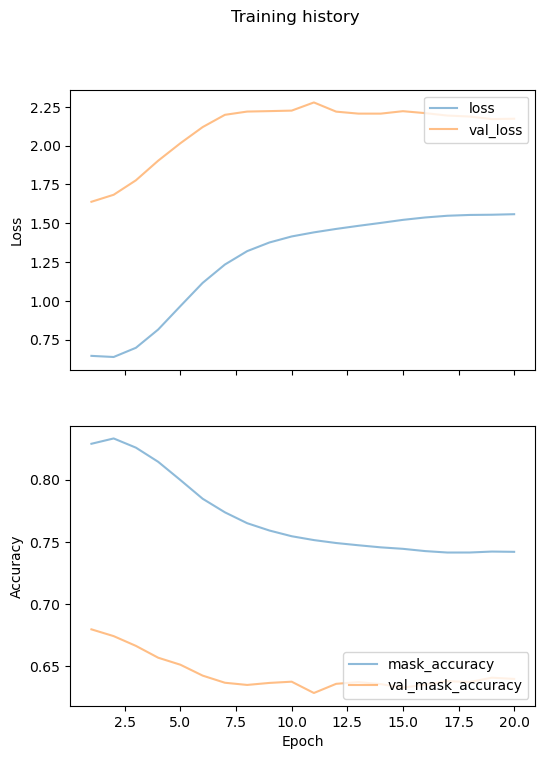

In [67]:
import matplotlib.pyplot as plt

# Visualizing Training History
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Training history')
x = list(range(1, 21))  # Assuming 20 epochs
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["mask_accuracy"], alpha=0.5, label="mask_accuracy")
axs[1].plot(x, history.history["val_mask_accuracy"], alpha=0.5, label="val_mask_accuracy")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="lower right")
plt.show()

In [ ]:
def translate(sentence):
    # Encode source sentence
    enc_tokens = eng_vect([sentence])  # (1, 25)
    # Vocabulary lookup
    lookup = fre_vect.get_vocabulary()
    start_token = "[start]"
    end_token = "[end]"
    # Decoder starts with [start]
    output_tokens = [start_token]

    for _ in range(seq_length - 1):  # decoder length = 24
        # Vectorize current decoder sequence
        vec = fre_vect([" ".join(output_tokens)])  # (1, 25)
        dec_tokens = vec[:, :-1]                   # (1, 24)
        # Model prediction
        logits = model([enc_tokens, dec_tokens])   # (1, 24, vocab)
        # Take last timestep
        step = len(output_tokens) - 1
        token_id = tf.argmax(logits[0, step]).numpy()
        word = lookup[token_id]
        output_tokens.append(word)
        end_id = fre_vect("[end]").numpy()[0]
        
        if token_id == end_id:
            break

    return " ".join(output_tokens)

# Test the model on sample test cases
test_count = 20
for n in range(test_count):
    eng_sent, fre_sent = random.choice(test_pair)
    translated = translate(eng_sent)
    print(f"Test case: {n}")
    print(f"English sentence: {eng_sent}")
    print(f"Translated sentence: {' '.join(translated)}")
    print(f"French sentence: {fre_sent}")
    print()